# Midterm 2, Spring 2023: Better Reads

_Version 1.0_

*All of the header information is important. Please read it.*

**Topics, number of exercises:** This problem builds on your knowledge of Numpy, pandas, database organization, graph abstractions, and basic Python (for interfacing with other Python libraries). It has **11** exercises, numbered 0 to **10**. There are **21** available points. However, to earn 100% the threshold is **12** points. (Therefore, once you hit **12** points, you can stop. There is no extra credit for exceeding this threshold.)

**Free points!** This exam includes one exercise, Exercise 3, whose points are "**free**." However, to get these points you need to read some text and _submit the notebook to the autograder at least once_.

**Exercise ordering:** Each exercise builds logically on previous exercises, but you may solve them in any order. Exercises are **not** necessarily ordered by difficulty, but higher point values usually imply more difficult tasks.

**Demo cells:** Code cells that start with the comment `### define demo inputs` will load results from prior exercises applied to the entire data set and use those to build demo inputs. These must be run for later demos to work properly but they do not affect the test cells. The data loaded by these cells may be large (at least in terms of human readability). You are free to inspect them, but we did not print them in the starter code.

**Debugging you code:** Right before each exercise test cell, there is a block of text explaining the variables available to you for debugging. You may use these to test your code and can print/display them as needed (careful when printing large objects, you may want to print the head or chunks of rows at a time).

**Exercise point breakdown:**

- Exercise 0: **2** points
- Exercise 1: **1** point
- Exercise 2: **3** points
- Exercise 3: **2** point **FREEBIE! Submit to record them**
- Exercise 4: **1** point
- Exercise 5: **2** points
- Exercise 6: **2** points
- Exercise 7: **1** point
- Exercise 8: **3** points
- Exercise 9: **2** points
- Exercise 10: **2** points

**Final reminders:** 

- Submit after **every exercise**
- Review the generated grade report after you submit to see what errors were returned
- Stay calm, skip problems as needed, and take short breaks at your leisure

# Background: Better Reads #

[Goodreads](https://www.goodreads.com/) is a website devoted to curating user-generated book reviews. You'll do some elementary data-mining to uncover "communities" of users who like the same books. Such insights might help users find like-minded communities and generate better book recommendations.

**Overall workflow.** This notebook has six (6) parts with about 1-3 exercises each.
* **Part A:** Analyze user-book interactions [SQL, pandas]
* **Part B:** Power-law analysis [pandas, Numpy]
* **Part C:** Edge lists, NetworkX, and graph clusters [Python, graphs]
* **Part D:** Finding communities via graph clustering [SQL, pandas]
* **Part E:** Identifying "top reads" by community [pandas]
* **Part F:** Merging inventory metadata [pandas]

In [3]:
### Global Imports
###
### AUTOGRADER TEST - DO NOT REMOVE
###

# Standard Python modules
import sys
import numpy as np
import pandas as pd
import sqlite3 as db

# Extra functions this notebook needs. Ignore these unless
# an exercise asks you to do otherwise.
import networkx as nx
import cse6040
from cse6040.utils import load_text_from_file, load_df_from_file, load_obj_from_file, load_table_from_db

# Getting started (modules) #

Skim the code cell below and then run it. Take note of the standard preloaded modules, `numpy as np`, `pandas as pd`, and `sqlite3 as db`, any or all of which you may need to construct your solutions.

The other functions are used by our demo and testing code. You can ignore them unless an exercise asks you to do otherwise.

In case it's helpful, here are the versions of Python and standard modules you are using:

In [4]:
print("* Python version: {}".format(sys.version.replace('\n', ' ')))
print(f"* Numpy version: {np.__version__}")
print(f"* pandas version: {pd.__version__}")
print(f"* sqlite3 version: {db.version}")

* Python version: 3.8.7 (default, Jan 25 2021, 11:14:52)  [GCC 5.5.0 20171010]
* Numpy version: 1.22.1
* pandas version: 1.4.0
* sqlite3 version: 2.6.0


## pandas versus SQL ##

The actual Goodreads data is provided via a SQLite3 database. However, only some exercises _require_ SQL; most exercises were designed with pandas in mind.

Nevertheless, even some of the pandas exercises can be solved using SQL. The cell below defines the function, `dfs_to_conn`, which can be used to create in-memory database connections. If you pass in a dictionary mapping table names to pandas `DataFrame` objects, then `dfs_to_conn` will return a `sqlite3` connection with all of the data in the `DataFrame` objects available under the names given as keys. You are also free to write to the in-memory database by creating tables, inserting, deleting, updating records, etc. Anything that SQLite3 allows should work.

**Example:**

```python
    my_df = pd.DataFrame({'A':[1,2,3], 'B': [4,5,6], 'C':['x', 'y', 'z']})
    print(my_df)
    #    A  B  C
    # 0  1  4  x
    # 1  2  5  y
    # 2  3  6  z
    conn = dfs_to_conn({'my_table': my_df})
    cur = conn.cursor()
    cur.execute('select A, B, C from my_table')
    result = cur.fetchall()
    conn.close() 
    print(result) # list of tuples, each tuple is a row
    #[(1, 4, 'x'), (2, 5, 'y'), (3, 6, 'z')]
```

In [5]:
def dfs_to_conn(conn_dfs, index=False):
    import sqlite3
    conn = sqlite3.connect(':memory:')
    for table_name, df in conn_dfs.items():
        df.to_sql(table_name, conn, if_exists='replace', index=index)
    return conn

# Goodreads Data (`grdbconn`) #

Some of the Goodreads data is stored in a SQLite3 database. The code cell below opens a read-only connection to it named **`grdbconn`**.

For now, don't worry about what's there. We will explain any tables you need in the exercises that use them.

In [6]:
# Goodreads database connection:
grdbconn = db.connect('file:resource/asnlib/publicdata/goodreads.db?mode=ro', uri=True)

# Part A: Analyzing user-book interactions #

> Includes Exercise 0 (2 points) and Exercise 1 (1 point).

The Goodreads dataset includes **user-book interactions.** An "user-book interaction" means the user "did something" with the book on the Goodreads website:

- _Viewed_: The user looked at a book description and saved it to their personal library.
- _Read_: The user marked the book as "read."
- _Rated_: The user gave the book a rating, from 1 to 5 stars.
- _Reviewed_: The user wrote a public review of the book on the website.

These interactions are recorded in a SQL table called `Interactions`. Let's have a quick look for one of the users whose integer ID is `840218`:

In [7]:
pd.read_sql(r"SELECT * FROM Interactions WHERE user_id=840218", grdbconn)

,user_id,book_id,is_read,rating,is_reviewed
0,840218,1012,1,5,0
1,840218,838000,0,0,0
2,840218,38884,1,4,0
3,840218,49559,1,4,0


Each row shows how this user interacted with some book. This user interacted with four books. However, they saved book `838000` (row 1) but did nothing else with it—that is, they did not read it, rate it, or review it.

They did rate books `1012`, giving it `5` stars, as well as `38884` and `49559`, giving both `4` stars. They did not review any book (`is_reviewed=0`). Had they done so, `is_reviewed` would be `1`. All values are integers.

## **Ex. 0 (2 pts)**: `summarize_interactions_str` ##

You are asked to write a summary report of the overall interactions. Complete the function
```python
def summarize_interactions_str(conn):
    ...
```
so that it does the following.

**Inputs:** The input is a SQLite3 database connection containing a table named `Interactions` with the fields `user_id`, `book_id`, `is_read`, `rating`, and `is_reviewed`, all containing integer values.

**Your task:** Calculate the following:

- The total number of interactions
- The number of _unique_ user IDs
- The number of _unique_ book IDs
- The number of interactions where the user ...
  - read the book, i.e., where `is_read` equals `1`;
  - rated the book, i.e., where `rating` is _greater than_ `0`;
  - reviewed the book, i.e., where `is_review` equals `1`.

**Output:** Generate and **return a string** that reports these results. The string should be formatted as follows:
```
There are 370,818 interactions.
- Unique users: 2,000
- Unique books: 138,633
- Number of reads: 208,701 (56.3% of all interactions)
- Number of ratings: 194,243 (52.4%)
- Number of reviews: 23,720 (6.4%)
```
In particular:
- Commas should be used every three digits to make the numbers more readable.
- The percentages should be reported to one digit after the decimal place (even if that digit is `0`, e.g., `37.0%`).
- Newlines should appear between lines as shown in the example. However, there should be _no_ leading or trailing whitespace.

**Additional notes and hints:**
1. The function predefines a string template for the report. It's probably easiest to **modify** this template to achieve the desired result.
2. You may assume that there are no duplicate (`user_id`, `book_id`) pairs.
3. Recall that Python f-strings can help format numbers. See the demo cell below.

In [8]:
### Demo: Recall Python's f-strings

print(f"`pi` to 2 decimal digits: `{3.14159265358979:0.2f}`")
print(f"Behold: `{1234567890:,}` -- neat!")

`pi` to 2 decimal digits: `3.14`
Behold: `1,234,567,890` -- neat!


In [9]:
### Define demo inputs

demo_conn_ex0 = db.connect(f'file:resource/asnlib/publicdata/demo_ex0.db?mode=ro', uri=True)
print("First five rows of the demo database:")
pd.read_sql(r"SELECT * FROM Interactions LIMIT 5", demo_conn_ex0)

First five rows of the demo database:


,user_id,book_id,is_read,rating,is_reviewed
0,344083,1050,1,3,0
1,47457,210745,0,0,0
2,159681,51033,0,0,0
3,226106,175390,0,0,0
4,41825,528,1,4,0


The demo included in the solution cell below should display the following output:
```
There are 12,345 interactions.
- Unique users: 1,766
- Unique books: 9,348
- Number of reads: 6,844 (55.4% of all interactions)
- Number of ratings: 6,389 (51.8%)
- Number of reviews: 744 (6.0%)
```

In [10]:
### Exercise 0 solution ###
def summarize_interactions_str(conn):
    
    import pandas as pd
   
    df = pd.read_sql('''
    SELECT count(*) as interactions, count(distinct user_id) as user, count(distinct book_id) as book,
    sum(is_read) as read, sum(rating > 0) as rating, sum(is_reviewed) as review
    FROM Interactions 
    ''', conn)
    
    dic = df.to_dict('index')[0]
    
    def helper (interactions, user, book, read, rating, review):
        return f"""There are {interactions:,} interactions.
- Unique users: {user:,}
- Unique books: {book:,}
- Number of reads: {read:,} ({100*read/interactions:0.1f}% of all interactions)
- Number of ratings: {rating:,} ({100*rating/interactions:0.1f}%)
- Number of reviews: {review:,} ({100*review/interactions:0.1f}%)"""
    
    return helper(**dic)
    
### demo function call
print(summarize_interactions_str(demo_conn_ex0))

There are 12,345 interactions.
- Unique users: 1,766
- Unique books: 9,348
- Number of reads: 6,844 (55.4% of all interactions)
- Number of ratings: 6,389 (51.8%)
- Number of reviews: 744 (6.0%)


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 0. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [11]:
### test_cell_ex0
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_0', 
    'func': summarize_interactions_str, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'conn':{
            'dtype': 'db', # data type of param.
            'check_modified': False,
        }
    },
    'outputs':{
        'output_0': {
            'index': 0,
            'dtype': 'str',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='resource/asnlib/publicdata/')
for _ in range(10):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME:** A correct implementation of `summarize_interactions_str`, when run on the full Goodreads dataset, would produce the following report:

In [12]:
### test_cell_ex0
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_0', 
    'func': summarize_interactions_str, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'conn':{
            'dtype': 'db', # data type of param.
            'check_modified': False,
        }
    },
    'outputs':{
        'output_0': {
            'index': 0,
            'dtype': 'str',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='resource/asnlib/publicdata/')
for _ in range(10):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


In [13]:
print(f"\n=== Report on the full dataset ===\n\n{load_text_from_file('ex0.txt')}")


=== Report on the full dataset ===

There are 370,818 interactions.
- Unique users: 2,000
- Unique books: 138,633
- Number of reads: 208,701 (56.3% of all interactions)
- Number of ratings: 194,243 (52.4%)
- Number of reviews: 23,720 (6.4%)


## **Ex. 1 (1 pt)**: `count_interactions_by` ##

Suppose we want to group the interactions and count the number by group. For example, we might want to know, for each unique user ID, how many interactions there are. Complete the function
```python
def count_interactions_by(col, conn):
    ...
```
so that it does the following.

**Inputs:**
- `col`: The name of a column
- `conn`: A database connection containing a table named `Interactions`

**Your task:** For each unique value in column `'col'` of the `Interactions` table, count how many interactions (rows) there are.

**Output:** Return a dataframe with two columns:
- `col`: A column with the **same name** as the given input column holding the unique values
- `'count'`: A column with the number of interactions for each unique value

Refer to the demo cell below for an example of this output.

**Additional notes and hints:** You may assume that `col` holds a valid column name. The exact order of rows and columns in your output does not matter.

**Example:**

In [14]:
### Define demo inputs ###

demo_col_ex1 = 'user_id'
demo_conn_ex1 = db.connect(f'file:resource/asnlib/publicdata/demo_ex1.db?mode=ro', uri=True)
display(pd.read_sql("SELECT * FROM Interactions", demo_conn_ex1))

,user_id,book_id,is_read,rating,is_reviewed
0,569241,208373,0,0,0
1,569241,47199,1,5,1
2,607817,40293,0,0,0
3,569241,47383,1,5,1
4,607817,7984,0,0,0
5,607817,792,0,0,0
6,604656,2345195,1,5,1
7,607817,128860,1,0,0


Calling `count_interactions_by(demo_col_ex1, demo_conn_ex1)` should produce the following output:

|   user_id |   count |
|----------:|--------:|
|    569241 |       3 |
|    604656 |       1 |
|    607817 |       4 |

However, calling `count_interactions_by('is_read', demo_conn_ex1)` would return a two-row `DataFrame` where the count of `0` and `1` values is `4` each.

In [15]:
### Exercise 1 solution
def count_interactions_by(col, conn):
    
    import pandas as pd
    
    
    query = f'''
    SELECT {col}, COUNT(*) AS count
    FROM Interactions
    GROUP BY {col}
    '''
    
    # OR GROUP BY 1
    
    result = pd.read_sql_query(query, conn)
  
    return result
   
### demo function calls ###
display(count_interactions_by(demo_col_ex1, demo_conn_ex1))
display(count_interactions_by('is_read', demo_conn_ex1))

,user_id,count
0,569241,3
1,604656,1
2,607817,4


,is_read,count
0,0,4
1,1,4


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 1. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [16]:
### test_cell_ex1
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_1', 
    'func': count_interactions_by, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'col': {
            'dtype': 'str', # data type of param.
            'check_modified': False,
        },
        'conn': {
            'dtype': 'db',
            'check_modified': False
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
#            'check_column_type': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME:** A correct implementation of `count_interactions_by`, when run on the full Goodreads dataset for the columns `is_read`, `rating`, and `is_reviewed`, would produce the following:

In [17]:
print(f"\n=== `count_interactions_by` on the full dataset ===\n")
for col_ in ['is_read', 'rating', 'is_reviewed']:
    display(load_df_from_file(f"ex1-{col_}.df"))


=== `count_interactions_by` on the full dataset ===



,is_read,count
0,0,162117
1,1,208701


,rating,count
0,0,176575
1,1,3821
2,2,10545
3,3,40965
4,4,67534
5,5,71378


,is_reviewed,count
0,0,347098
1,1,23720


> **Aside (skip if pressed for time)**: From these results, you might observe a _hint_ at a phenomenon known as a [_monotonic behavior chain_](https://dl.acm.org/doi/10.1145/3240323.3240369): the total number of interactions > the number who read > the number who rate > the number who review. Such phenomena have been used to improve automatic generation of item recommendations.

# Part B: Power laws #

> Includes Exercise 2 (3 points).

Many types of real-world data have _**power law distributions**_. Roughly speaking, a probability density $f(x)$ is a power law if it behaves like $\dfrac{1}{x^d}$ for some constant $d$ when $x$ is "large," i.e., as one approaches the tail of the distribution. Let's see if there are any power laws in our data.

For instance, suppose you have a pandas `Series` that shows, for each user, how many books they interacted with:

In [18]:
ux_counts = load_df_from_file(f"ex1-user_id.df").set_index('user_id')['count']
ux_counts

user_id
175       349
1251      146
1369      127
1764      278
1773      225
         ... 
874199     12
874412     93
874916     87
875838     55
876114     57
Name: count, Length: 2000, dtype: int64

The index is a user ID and the value is an integer count of how many interaction-rows are associated with them.

## **Ex. 2 (3 pts)**: `log2bin_count` ##

Given a `Series` object holding values that can range from 1 to $n$, inclusive, we wish to count how many of those integers lie within the _log-two bins_,

* $[1, 2)$: that is, starting at one up to but _excluding_ 2;
* $[2, 4)$: starting at two up to but _excluding_ 4;
* $[4, 8)$: starting at 4 up to but _excluding_ 8;
* ...
* and $\left[ 2^{k-1}, 2^k \right)$: starting at $2^{k-1}$ up to but excluding $2^k$, where $2^k$ is the first power of two greater than $n$.

Complete the function,
```python
def log2bin_count(series):
    ...
```
to compute these counts.

**Inputs:** The input `series` is a pandas `Series`-object holding the values.

**Your tasks** will involve, most likely, these steps:
- Determine what the bins need to be.
- Count the number of values in each bin.
- Exclude any empty bins, i.e., those with _no_ values.

**Outputs:** Your function should return a `DataFrame` with two columns:
1. `bin_start`: The value of the left edge of a bin, which are integers starting at 1 and all of the form $2^i$.
2. `count`: The number of values in `series` that lie in $\left[ 2^i, 2^{i+1} \right)$, also an integer.

See the demo below for an example.

**Additional notes and hints.**
1. You may assume all input values are integers greater than or equal to 1.
1. Given a value $x$, the next largest power of two is $2^k$ where $k = \lceil \log_2 x \rceil + 1$.
1. A helpful function is [`pandas.cut` (`pd.cut`)](https://pandas.pydata.org/docs/reference/api/pandas.cut.html), but you certainly do not have to use it.
1. Recall that you should _omit_ empty bins.

**Example/demo:** Suppose the input `Series` looks like the following:

In [19]:
### Define demo inputs ###

demo_series_ex2 = load_df_from_file('demo_ex2.df').set_index('user_id')['count']
display(demo_series_ex2)

user_id
752564     76
365745    373
405247    385
83287     142
363597    133
676898     49
795294     78
736928     19
594854     37
62913     119
Name: count, dtype: int64

Then a correct solution would produce:

|   bin_start |   count |
|------------:|--------:|
|          64 |       3 |
|         256 |       2 |
|         128 |       2 |
|          32 |       2 |
|          16 |       1 |

There is just one input value in $[16, 32)$, namely, the value `49`. But in the bin $[64, 128)$, there are three input values: `76`, `78`, and `119`.

In [20]:
### Exercise 2 solution
def log2bin_count(series):
    
    max_pow = int(np.ceil(np.log2(max(series))))
    bins = 2 ** np.arange(max_pow + 1) #array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])
    series_cut = pd.cut(series, bins, right=False).apply(lambda i: i.left).astype('int64').value_counts()\
    .reset_index().rename(columns={'index':'bin_start', 0:'count'})
    
    return series_cut

### demo function call ###
log2bin_count(demo_series_ex2)

,bin_start,count
0,64,3
1,256,2
2,128,2
3,32,2
4,16,1


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 2. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [21]:
### test_cell_ex2
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_2', 
    'func': log2bin_count, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'series': {
            'dtype': 'series',
            'check_modified': True,
        }
    },
    'outputs':{
        'output_0':{
            'index': 0,
            'dtype': 'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME:** A correct implementation of `log2bin_count`, when run on `ux_counts` from the full Goodreads dataset, would produce the following:

In [22]:
ux_counts

user_id
175       349
1251      146
1369      127
1764      278
1773      225
         ... 
874199     12
874412     93
874916     87
875838     55
876114     57
Name: count, Length: 2000, dtype: int64

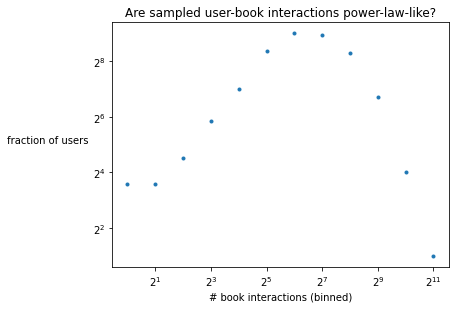

In [23]:
ux_counts_log2bins = load_df_from_file('ex2-log2bin_count.df')
ax = cse6040.utils.plot_series_loglog(ux_counts_log2bins.set_index('bin_start')['count'], base=2)
ax.set_xlabel('# book interactions (binned)')
ax.set_ylabel('fraction of users', rotation=0, horizontalalignment='right')
ax.set_title('Are sampled user-book interactions power-law-like?')
ax.set_aspect(1.0)

> **Aside (skip if pressed for time):** These interactions do, indeed, appear to follow a power law in the tail of the distribution. In fact, the data in this notebook is a relatively small sample of the full dataset, which consists of hundreds of millions of interactions and has an even longer tail consistent with a power law.

# Part C: NetworkX 101 #

> Includes Exercise 3 (the **freebie**; 2 points).

Your next major task is to learn a little bit about **NetworkX**, a popular Python package for analyzing relational data (graphs with vertices and edges).

**You do not have to write any code in this part; just read, learn, and enjoy! However, you do need to run Exercise 3's test cell and submit the exam to get its "free" points.**

Also, do pay attention: subsequent exercises will use some of these concepts.

## **Ex. 3 (_FREE_ 2 pts)**: Edge lists ##

One way to use NetworkX is to create your graph as an **edge list**, which is a Python list of tuples. Each tuple `(u, v, w)` means that vertex `u` connects to vertex `v` and that this edge from `u` to `v` has a weight `w`.

For example, here are the first five elements of an edge list for a randomly generated graph.

In [24]:
demo_edge_list = cse6040.utils.random_clusters(4, 6, rng_or_seed=1_234, verbose=True) 

print(f"\nThe `demo_edge_list` has {len(demo_edge_list)} tuples. The first ten are:")
demo_edge_list[:10]

Constructing a vertex-clustered graph with these properties:
- Number of clusters: nc=4
- Vertices per cluster: nvc=6
- Number of intra-cluster edges per vertex: 4 (p_intra=0.5)
- Number of inter-cluster edges per vertex: 2 (p_inter=0.1)
- RNG: Generator(PCG64)

The `demo_edge_list` has 144 tuples. The first ten are:


[(0, 2, 0.31909705841419755),
 (0, 3, 0.11809123296664281),
 (0, 4, 0.2417662932527851),
 (0, 5, 0.3185339287822264),
 (0, 10, 0.026364980427509378),
 (0, 20, 0.04410061220535114),
 (1, 0, 0.6598743479594311),
 (1, 2, 0.7357576983159544),
 (1, 4, 0.22275365813138726),
 (1, 5, 0.17206618466113854)]

Let's use NetworkX to draw the graph that this edge list represents.

> (We've written wrappers around the corresponding NetworkX routines to hide some unnecessary detail.)

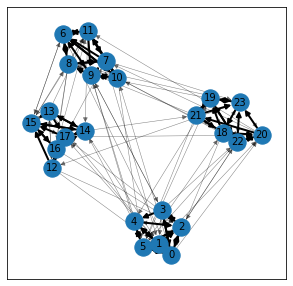

In [25]:
from cse6040.utils import to_nx, graph_spy

demo_G = to_nx(demo_edge_list) # Convert edge list to NetworkX graph
graph_spy(demo_G, style='graph', with_labels=True, figsize=(5, 5)); # Draw a picture

In this picture, the numbered circles are vertices and arrows indicate edges that go from one vertex to another. The edges are weighted, so in the picture, edges with "large" or "heavy" weights are darker and thicker than "small" or "light" weights.

The picture shows clear structure: there appear to be four **clusters** of vertices connected by heavy edges, and between these clusters there are only light edges.

To summarize, the NetworkX concepts you just saw are:

1. To use NetworkX, we need to construct **edge lists**, which are lists of tuples, `(u, v, w)`, where each tuple represents a weighted directed edge from `u` to `v` with weight `w`.
2. Our later analysis will look for **clusters** in a given network, which we will build from our data.

When you are ready, execute the cell below and submit to be sure your free points for Exercise 3 are recorded.

In [26]:
### test_cell_ex3 — a freebie ###

pass

print('Passed! Please submit.')

Passed! Please submit.


# Part D: Finding communities via graph clustering #

> Includes Exercise 4 (1 point) and Exercise 5 (2 points).

**User-user interactions.** Our dataset tells us which users have viewed, read, rated, and/or reviewed the same books. We will use this fact to "connect" users to one another in a graph, and then use NetworkX to find clusters ("communities") of users.

## **Ex. 4 (1 pt)**: `form_analysis_sample` ##

If a user gave a book a rating of 4 stars or more, that is a strong signal of interest in the book. Let's start by focusing on those interactions. Complete the following function as specified.

```python
def form_analysis_sample(conn):
    ...
```

**Inputs:** `conn` is a database connection to a database with an `Interactions` table, as used in Exercises 0 and 1.

**Your task:** Return the subset of interactions where the rating is 4 or more.

**Outputs:** Return the subset of rows of `Interactions` as a pandas `DataFrame`.

**Example.** Recall the demo `Interactions` table from Exercise 1:

In [27]:
### Define demo inputs ###

demo_conn_ex4 = db.connect(f'file:resource/asnlib/publicdata/demo_ex1.db?mode=ro', uri=True)
display(pd.read_sql("SELECT * FROM Interactions", demo_conn_ex4))

# use the naming convention `demo_<parameter name>_ex<exercise number>`
# for example if the function for exercise 3 has a parameter `df`, the demo variable should be named `demo_df_ex3`

,user_id,book_id,is_read,rating,is_reviewed
0,569241,208373,0,0,0
1,569241,47199,1,5,1
2,607817,40293,0,0,0
3,569241,47383,1,5,1
4,607817,7984,0,0,0
5,607817,792,0,0,0
6,604656,2345195,1,5,1
7,607817,128860,1,0,0


A correct implementation of `form_analysis_sample` should return the following `DataFrame`:

|   user_id |        book_id |   is_read |   rating |   is_reviewed |
|----------:|---------------:|----------:|---------:|--------------:|
|    569241 | 47199          |         1 |        5 |             1 |
|    569241 | 47383          |         1 |        5 |             1 |
|    604656 | 2345195        |         1 |        5 |             1 |

This output includes just the three rows where `rating` is `5`.

> **Note:** Although this example does not contain ratings with the value `4`, if it did, they would be included in the output.

In [28]:
### Exercise 4 solution
def form_analysis_sample(conn):
   
    
#     query='''
#     SELECT *
#     FROM Interactions
#     WHERE rating >= 4      
#     '''
    
    #df = pd.read_sql(query, conn)
    
    df = pd.read_sql('SELECT * FROM Interactions', conn)
    df = df.loc[df['rating'] >= 4, :]
    if df.shape[0] == 0:
        df = df.astype('object')
    
    return df

### demo function call ###
form_analysis_sample(demo_conn_ex4)

,user_id,book_id,is_read,rating,is_reviewed
1,569241,47199,1,5,1
3,569241,47383,1,5,1
6,604656,2345195,1,5,1


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 4. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [29]:
### test_cell_ex4
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_4', 
    'func': form_analysis_sample, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'conn':{
            'dtype': 'db', # data type of param.
            'check_modified': False,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## **Ex. 5 (2 pts)**: `connect_users` ##

Given the analysis sample from Exercise 4, let's "connect" users.

Let's say that two users `a` and `b` are **connected** if they both gave ratings of 4 or higher to the same book. The number of unique books they both rated this way is a measure of how strong their connection is.

Complete the following function to help identify these connections.
```python
def connect_users(ubdf, threshold):
    ...
```

**Inputs:**
- `ubdf`: A "user-book" dataframe having these two columns: `user_id` and `book_id`. Each row indicates that a given user gave a given book a rating of 4 or higher.
- `threshold`: An integer threshold on connection strength.
        
**Your tasks:** Determine which pairs of users are connected. Count how many books connect them. Drop self-pairs (`user_id_x == user_id_y`), as well as any pairs with fewer than `threshold` connections.

**Outputs:** Return a **new** `DataFrame` with three columns:
1. `user_id_x`: A user ID
2. `user_id_y`: Another user ID
3. `count`: The number of books they both rated in common. Recall that this value should be `>= threshold`.

**Additional notes and hints.**
1. Omit self-pairs, that is, cases where `user_id_x` == `user_id_y`.
1. Return pairs **symmetrically**. That is, if the pair of users (`a`, `b`) have a count `k` at or above the threshold, then **both** (`a`, `b`, `k`) and (`b`, `a`, `k`) should be rows in the output table.
1. If no connections meet the threshold, you should return an empty `DataFrame` _with_ the specified columns.
1. You may assume there are no duplicate rows.

> _Aside:_ For really huge datasets (not what is included in this exam), dropping users with fewer than `threshold` ratings _before_ looking for pairs might be a bit faster.

**Example:** Suppose the inputs are the `DataFrame` shown below with a target connection threshold of `2`:

In [30]:
### Define demo inputs ###

demo_ubdf_ex5 = load_df_from_file("demo_ex5.df").sort_values(['book_id', 'user_id']).reset_index(drop=True)
demo_threshold_ex5 = 2

display(demo_ubdf_ex5)

,user_id,book_id
0,1,2
1,0,7
2,2,7
3,0,19
4,2,19
5,2,22
6,1,38
7,0,41
8,3,41
9,0,85


For this input, `connect_users` should produce:

|   user_id_x |   user_id_y |   count |
|------------:|------------:|--------:|
|           0 |           2 |       2 |
|           0 |           3 |       2 |
|           2 |           0 |       2 |
|           3 |           0 |       2 |

Users `0` and `2` both rated books `7` and `19`, so they meet the threshold of having reviewed 2 books in common. User `1` did not review any books in common with any other user, and so they do not appear in any pair of the output.

In [64]:
### Exercise 5 solution
def connect_users(ubdf, threshold):
    
    ubdf_new = ubdf.merge(ubdf, on='book_id')
    
    ubdf_new = ubdf_new[ubdf_new['user_id_x'] != ubdf_new['user_id_y']]
   
    ubdf_new = ubdf_new.groupby(['user_id_x', 'user_id_y'], as_index = False)['book_id'].count()
    
    ubdf_new = ubdf_new.rename(columns={'book_id' : 'count'})
    
    ubdf_new = ubdf_new[ubdf_new['count'] >= threshold]
    
    return ubdf_new 


#     return ubdf.merge(ubdf, on='book_id').query('user_id_x != user_id_y').\
# groupby(['user_id_x', 'user_id_y'], as_index = False).count().rename(columns={'book_id' : 'count'}).\
# query(f'count >= {threshold}')


### demo function call ###
connect_users(demo_ubdf_ex5, demo_threshold_ex5)

,user_id_x,user_id_y,count
0,0,2,2
1,0,3,2
2,2,0,2
3,3,0,2


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 5. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [65]:
### test_cell_ex5
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_5', 
    'func': connect_users, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'ubdf': {
            'dtype': 'df', # data type of param.
            'check_modified': True
        },
        'threshold': {
            'dtype': 'int',
            'check_modified': False
        }
    },
    'outputs':{
        'output_0':{
            'index': 0,
            'dtype': 'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME:** From a correct implementation of `connect_users`, one way we can "draw" the connectivity is to form a sparse matrix where nonzeros represent connections. Here is a picture of this matrix for the full dataset, using a threshold of 2:

A sample of connections:


,user_id_x,user_id_y,count
0,175,1251,5
1,175,1369,4
2,175,1764,2
3,175,3164,5
4,175,3303,6


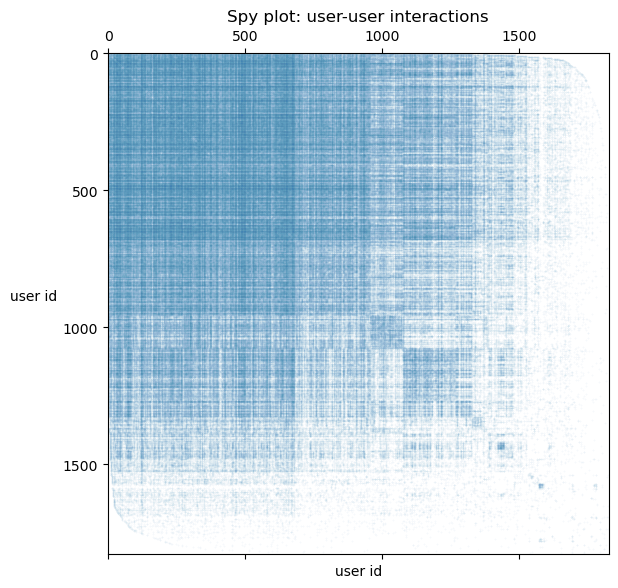

In [66]:
uudf = load_df_from_file('ex5.df') # user-user table

print("A sample of connections:")
display(uudf.head())

if False: # Disabled due to NetworkX version incompatibility issue (fix pending)
    uudf_G = cse6040.utils.to_nx(uudf.to_records(index=False))
    ax_ex5 = cse6040.utils.graph_spy(uudf_G, markersize=0.01)
    ax_ex5.set_title('Spy plot: user-user interactions')
    ax_ex5.set_xlabel('user id')
    ax_ex5.set_ylabel('user id', rotation=0, horizontalalignment='right');
else:
    cse6040.utils.display_image_from_file('resource/asnlib/public/demo-user-user-spy.png')

> **Aside (skip if pressed for time):** The "grid-like" pattern you might see suggests that there are groups or clusters of interconnected users in the data. Our next task will try to identify them.

# Part E: Identifying "top reads" by community #

> Includes Exercise 6 (2 points), Exercise 7 (1 point), and Exercise 8 (3 points).

The NetworkX package contains several algorithms for **detecting communities**, that is, clusters of "strongly interconnected" vertices in a graph (recall Part C).

We ran one of these algorithms on a graph formed from the user-user interactions you calculated in Part D. The algorithm grouped users (graph vertices) into clusters.

It returned these clusters as a **list of sets**, where each set is a "community" of user IDs grouped together. Since users were connected for liking the same books, it's possible users in the same community have similar tastes.

Here is the communities object that NetworkX produced for us:

In [67]:
communities = load_obj_from_file('demo_ex6.obj')

It is a list of sets:

In [68]:
type(communities), type(communities[0])

(list, set)

Here is how many communities there are:

In [69]:
len(communities)

6

The sizes of the 6 communities are:

In [70]:
[len(c) for c in communities]

[868, 2, 36, 340, 6, 574]

Let's print the smaller two:

In [71]:
print("Community 1:", communities[1])
print("Community 4:", communities[4])

Community 1: {430689, 687415}
Community 4: {154369, 676898, 542723, 677611, 649588, 332535}


The values you see are user IDs.

## **Ex. 6 (2 pts)**: `assign_communities` ##

To merge this data with our existing database, we need to convert the Python `communities` data structure into a `DataFrame`. Complete the function below to aid in this task:

```python
def assign_communities(communities):
    ...
```

**Inputs:** The input `communities` is a list of sets of integers, as in the previous example.

**Your task:** Convert this input into a dataframe.

**Returns:** Your function should return a `DataFrame` with these columns:
- `user_id`: A user ID (an integer).
- `comm_id`: The ID of the community it belongs to (also an integer).

The community ID is its index in `communities`. That is, community `0` is stored in `communities[0]`, community `1` is in `communities[1]`, and so on.

**Example:** Consider this set of communities:

In [72]:
### Define demo inputs ###

demo_communities_ex6 = [{1, 3, 10, 17}, {2, 6, 13, 15}, {0, 5, 11, 16}, {9, 14}, {4, 7, 8, 12}]

A correct implementation of `assign_communities` would produce this result:

|   user_id |   comm_id |
|----------:|----------:|
|         1 |         0 |
|        10 |         0 |
|         3 |         0 |
|        17 |         0 |
|         2 |         1 |
|        13 |         1 |
|         6 |         1 |
|        15 |         1 |
|         0 |         2 |
|        16 |         2 |
|        11 |         2 |
|         5 |         2 |
|         9 |         3 |
|        14 |         3 |
|         8 |         4 |
|         4 |         4 |
|        12 |         4 |
|         7 |         4 |

In [77]:
### Exercise 6 solution
def assign_communities(communities):
    
    from collections import defaultdict
    
    dic = defaultdict(int)
    
    for i, v in enumerate(communities):
        for x in v:
            dic[x] = i
        
    df = pd.DataFrame(dic.items(), columns=['user_id', 'comm_id'])
    
    return df
    
#     load = [{'user_id': user_id, 'comm_id': i} for i, comm in enumerate(communities) for user_id in comm]
#     return pd.DataFrame(load)

### demo function call ###
assign_communities(demo_communities_ex6)

,user_id,comm_id
0,1,0
1,10,0
2,3,0
3,17,0
4,2,1
5,13,1
6,6,1
7,15,1
8,0,2
9,16,2


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 6. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [78]:
### test_cell_ex6
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_6', 
    'func': assign_communities, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'communities': {
            'dtype': 'list', # data type of param.
            'check_modified': True,
        }
    },
    'outputs':{
        'output_0':{
            'index': 0,
            'dtype': 'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## **Ex. 7 (1 pt)**: `means_by_community` ##

Suppose we wish to calculate means (averages) of the interaction data _by community._ Implement the function,

```python
def means_by_community(intdf, comdf):
    ...
```

to perform this task.

**Inputs:**
1. `intdf`: An interactions `DataFrame` with columns `user_id`, `book_id`, `is_read`, `rating`, and `is_reviewed`.
1. `comdf`: A communities `DataFrame` with columns `user_id` and `comm_id`.

**Your task:** Join these `DataFrames` and then return a new `DataFrame` with the mean values of the `is_read`, `rating`, and `is_reviewed` columns **by community.**

**Outputs:** Your function should return a new `DataFrame` with these columns:
1. `comm_id`: An integer community ID, one per row.
2. `is_read`, `rating`, `is_reviewed`: The mean value of each column for all rows of `intdf` for all users of the community. These should be stored as `float` values.

**Additional notes:** A user ID might not appear in both inputs. These should not be part of any means calculation.

**Example:** Consider the following two inputs:

In [79]:
### Define demo inputs ###

demo_intdf_ex7 = load_table_from_db("Interactions", "demo_ex7.db").sort_values(by='user_id')
demo_comdf_ex7 = load_table_from_db("Communities", "demo_ex7.db").sort_values(by='user_id')

display(demo_intdf_ex7)
display(demo_comdf_ex7)

,user_id,book_id,is_read,rating,is_reviewed
3,23193,5103,1,5,0
2,34369,1286322,1,4,0
1,110781,13565,1,5,0
0,141064,919,1,5,0
4,437014,215715,1,4,0


,user_id,comm_id
1,23193,5
3,110781,0
0,141064,3
2,437014,0


A correct implementation of `means_by_community` will return:

|   comm_id |   is_read |   rating |   is_reviewed |
|----------:|----------:|---------:|--------------:|
|         0 |         1 |      4   |             0 |
|         5 |         1 |      4.5 |             0 |

Observe that user `25031`, who has `is_reviewed=1`, does not belong to any community. Thus, that user does not affect the mean values for `is_reviewed`.

In [80]:
### Exercise 7 solution
def means_by_community(intdf, comdf):
    
    df = intdf.merge(comdf, how='inner', on='user_id')
    df = df.drop(['user_id','book_id'], axis=1)
    df = df.groupby('comm_id', as_index=False).mean()
    
    return df
    
### demo function call ###
demo_result_ex7 = means_by_community(demo_intdf_ex7, demo_comdf_ex7)
display(demo_result_ex7)

,comm_id,is_read,rating,is_reviewed
0,0,1.0,4.5,0.0
1,3,1.0,5.0,0.0
2,5,1.0,5.0,0.0


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 7. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [81]:
### test_cell_ex7
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_7', 
    'func': means_by_community, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'intdf': {
            'dtype': 'df', # data type of param.
            'check_modified': True,
        },
        'comdf': {
            'dtype': 'df',
            'check_modified': True
        }
    },
    'outputs':{
        'output_0':{
            'index': 0,
            'dtype': 'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME:** With a correct `means_by_community`, we can see whether the communities differ in how they read, rate, and review books. Here is what would happen if we ran on the full dataset:

In [82]:
ex7_means = load_df_from_file('ex7-means.df')
print(f"Recall: community sizes: {[(k, len(c)) for k, c in enumerate(communities)]}")
ex7_means

Recall: community sizes: [(0, 868), (1, 2), (2, 36), (3, 340), (4, 6), (5, 574)]


,comm_id,is_read,rating,is_reviewed
0,0,1.0,4.481228,0.105068
1,1,1.0,4.945455,0.427273
2,2,1.0,4.418115,0.267155
3,3,1.0,4.505879,0.128845
4,4,1.0,4.366142,0.110236
5,5,1.0,4.560539,0.121930


## **Ex. 8 (3 pts):** `get_topreads_by_community` ##

Suppose we merge the community information into the interactions database. Can we then identify which books each community is "the most interested in?" Complete the following function to help answer this question:

```python
def get_topreads_by_community(xcdf, rank):
    ...
```

**Inputs:** There are two inputs:
1. `xcdf` is a `DataFrame` with the following columns:
  * `user_id`: A user ID (integer)
  * `book_id`: A book ID (integer) that this user read
  * `comm_id`: The community ID to which the user belongs (integer)
2. `rank` is an integer indicating how many of the top books we want to return. For instance, if `rank=5`, then we want results for just the top 5 books in each community.

**Your task:** For each community, calculate what _percentage_ of its users read each book. That is, we would like to be able to see something like "in Community 2, 25% of the users read book 238." We then want to identify the top `rank` books.

There are several strategies for this exercise, but you might consider something along these lines.
- Determine the number of unique users in each community. You need this information to get percentages.
- Determine how many users read each book by community.
- Normalize these counts by the community size.
- Sort and return the results, retaining just the top `rank` books in each community.

**Outputs:** Your function should return a new `DataFrame` with the following columns:
- `comm_id`: The community ID
- `book_id`: A book ID that was read in that community
- `percent`: The percentage of the community that read that book.
- `comm_size`: The number of users in the community

As noted above, return **at most** the top `rank` books per community. In the event of ties, retain books with the lowest ID. (This choice is arbitrary but will simplify your implementation.)

**Additional notes and hints:** If your code calculates a fraction, don't forget to multiply by 100 to get a percentage value for your final output.

**Example:** Consider this input dataframe and a target rank of 2:

In [83]:
### Define demo inputs ###

demo_xcdf_ex8 = load_df_from_file('demo_ex8.df').reset_index(drop=True)
demo_rank_ex8 = 2

demo_xcdf_ex8

,user_id,book_id,is_read,rating,is_reviewed,comm_id
0,793590,996,1,4,0,0
1,619091,6989,1,5,0,5
2,135105,1386,1,5,0,5
3,776616,461,1,4,0,0
4,172315,997,1,4,0,3
...,...,...,...,...,...,...
95,614807,1574,1,4,0,5
96,405247,996,1,5,1,0
97,181951,1604,1,4,0,3
98,124016,944,1,5,0,5


From the demo input shown above, your function should return:

|   comm_id |   book_id |   percent |   comm_size |
|----------:|----------:|----------:|------------:|
|         0 |       821 |   7.89474 |          38 |
|         0 |       536 |   5.26316 |          38 |
|         3 |       938 |  12.5     |          32 |
|         3 |       943 |   9.375   |          32 |
|         5 |      1386 |  12       |          25 |
|         5 |      1473 |  12       |          25 |

In [100]:
### Exercise 8 solution
def get_topreads_by_community(xcdf, rank=5):
    
    def helper(group): 
        df = group.groupby('book_id', as_index=False).size()
        df = df.rename(columns={'size':'book_count'})
        df['comm_size'] = group['user_id'].unique().shape[0]
        df = df.sort_values(['book_count','book_id'], ascending=[False, True])
        df['percent'] = 100 * df['book_count']/df['comm_size']
        return df.iloc[:rank, :]
    
    return xcdf.groupby('comm_id').apply(helper).reset_index().drop(columns=['level_1','book_count'])

### demo function call ###
get_topreads_by_community(demo_xcdf_ex8, demo_rank_ex8)

,comm_id,book_id,comm_size,percent
0,0,821,38,7.894737
1,0,536,38,5.263158
2,3,938,32,12.500000
3,3,943,32,9.375000
4,5,1386,25,12.000000
5,5,1473,25,12.000000


**RUN ME:** If your function was working correctly, you would identify these top books by community on the full dataset.

In [101]:
ex8_topreads = load_df_from_file('ex8-output.df')
ex8_topreads

,comm_id,book_id,percent,comm_size
0,0,786,28.110599,868
1,0,821,22.580645,868
2,0,943,21.428571,868
3,0,1012,20.852535,868
4,0,858,20.506912,868
5,1,25883,100.000000,2
6,1,27949,100.000000,2
7,1,52388,100.000000,2
8,1,62026,100.000000,2
9,1,62027,100.000000,2


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 8. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [102]:
### test_cell_ex8
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_8', 
    'func': get_topreads_by_community, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'xcdf': {
            'dtype': 'df', # data type of param.
            'check_modified': True,
        },
        'rank': {
            'dtype': 'int',
            'check_modified': False
        }
    },
    'outputs':{
        'output_0':{
            'index': 0,
            'dtype': 'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


# Part F (final part!): Merging inventory metadata #

> Includes Exercises 9 and 10 (2 points each).


To interpret the communities, we need to bring in some book-inventory metadata, like book titles and genres. Once we've done so, will the communities make sense?

## Genre vectors ##

The original dataset includes information on _genres_ for each book:

In [103]:
genres = pd.read_sql("SELECT * FROM Genres", grdbconn)
genres

,inv_id,genres
0,6066819,"{""fiction"": 555, ""romance"": 23, ""mystery, thri..."
1,89375,"{""non-fiction"": 534, ""history, historical fict..."
2,89376,"{""non-fiction"": 163}"
3,89377,"{""fiction"": 425, ""history, historical fiction,..."
4,28492512,"{""fantasy, paranormal"": 1}"
...,...,...
138628,6093345,"{""non-fiction"": 45, ""history, historical ficti..."
138629,1885731,"{""fantasy, paranormal"": 54163, ""young-adult"": ..."
138630,20997073,"{""romance"": 1}"
138631,2527820,"{""mystery, thriller, crime"": 23, ""fiction"": 6,..."


It's a bit messy, however: the genre information is stored as a JSON-formatted Python string encoding a **genre vector**:

In [104]:
# Inspect the very first genre entry:
print(f"* Type: `{type(genres['genres'].iloc[0])}`")
print(f"* Value: '{genres['genres'].iloc[0]}'")

* Type: `<class 'str'>`
* Value: '{"fiction": 555, "romance": 23, "mystery, thriller, crime": 10}'


This genre vector says that this particular book mixes three genres: `fiction`, `romance`, and `"mystery, thriller, crime"` (considered a single genre). Each value measures the relevance of that genre to the book.

> Roughly speaking, let's interpret `555` as meaning this book is 555 / (555+23+10) ~ 94.3% "fiction" and 23 / (555+23+10) ~ 3.9% "romance."

The database stores these as genre vectors as strings. However, we can easily convert them to Python dictionaries using the following helper function, `from_json_str`:

In [105]:
def from_json_str(s):
    """Parses the JSON string `s` and returns a Python object."""
    from json import loads
    return loads(s)


# Demo #

print("iloc 0:", from_json_str(genres['genres'].iloc[0]))
print("iloc 1:", from_json_str(genres['genres'].iloc[1]))

iloc 0: {'fiction': 555, 'romance': 23, 'mystery, thriller, crime': 10}
iloc 1: {'non-fiction': 534, 'history, historical fiction, biography': 178, 'fiction': 16, 'comics, graphic': 6}


We will treat these as (mathematical) vectors that we can "add." Here is a simple function to compute the sum of two genre vectors:

In [106]:
def add_genre_vecs(x, y):
    """Returns the sum of two genre vectors."""
    from collections import defaultdict
    z = defaultdict(int)
    for k, v in x.items():
        z[k] += v
    for k, v in y.items():
        z[k] += v
    return dict(z) # Converts into a regular Python dict

# Demo: start with two genre vectors, converted to `dict`:
demo_genre_vec_a = from_json_str(genres['genres'].iloc[0])
demo_genre_vec_b = from_json_str(genres['genres'].iloc[1])

# Add them:
add_genre_vecs(demo_genre_vec_a, demo_genre_vec_b)

{'fiction': 571,
 'romance': 23,
 'mystery, thriller, crime': 10,
 'non-fiction': 534,
 'history, historical fiction, biography': 178,
 'comics, graphic': 6}

## **Ex. 9 (2 pts)**: `merge_genre_vecs` ##

Suppose you are given a pandas `Series` whose values are JSON strings encoding individual genre vectors. Complete the function,
```python
def merge_genre_vecs(series):
    ...
```
so that it combines the genre vectors into a single, **normalized** genre vector.

**Inputs:** The input is a `Series` object containing Python strings. Each string is a JSON-formatted genre vector.

**Your task:**
- Convert every JSON string into a Python dictionary. Use or adapt `from_json_str` from above.
- Compute the "sum" of all these dictionaries. Use or adapt `add_genre_vecs` from above.

The result of the previous two steps is a **single dictionary**. The final step is to _normalize_ this result. That is, divide each value of the result by the sum of all the values.

**Outputs:** Your function should return the normalized genre vector as a Python dictionary.

**Example:** Consider the following example input, a `Series` of JSON strings:

In [107]:
### Define demo inputs ###

demo_series_ex9 = pd.Series(
    ['{"fiction": 555, "romance": 23, "mystery, thriller, crime": 10}',
     '{"non-fiction": 534, "history, historical fiction, biography": 178, "fiction": 16, "comics, graphic": 6}',
     '{"non-fiction": 163}',
     '{"fiction": 425, "history, historical fiction, biography": 330, "young-adult": 93, "children": 190}',
     '{"fantasy, paranormal": 1}'])

print(demo_series_ex9)

0    {"fiction": 555, "romance": 23, "mystery, thri...
1    {"non-fiction": 534, "history, historical fict...
2                                 {"non-fiction": 163}
3    {"fiction": 425, "history, historical fiction,...
4                           {"fantasy, paranormal": 1}
dtype: object


A correct `merge_genre_vecs` implementation should return the dictionary,

```python
{'fiction': 0.39461172741679873,
 'romance': 0.009112519809825673,
 'mystery, thriller, crime': 0.003961965134706815,
 'non-fiction': 0.27614896988906495,
 'history, historical fiction, biography': 0.20126782884310618,
 'comics, graphic': 0.002377179080824089,
 'young-adult': 0.036846275752773376,
 'children': 0.07527733755942947,
 'fantasy, paranormal': 0.0003961965134706815}
```

In [112]:
### Exercise 9 solution
def merge_genre_vecs(series):
    import json
    
    lod = [from_json_str(s) for s in series]
    
    result_d ={}
    total = 0
    
    for d in lod:
        for k, v in d.items():
            result_d[k] = result_d.get(k, 0) + v
            total += v
    
    return {k: v/total for k, v in result_d.items()}
        
### demo function call ###
merge_genre_vecs(demo_series_ex9)

{'fiction': 0.39461172741679873,
 'romance': 0.009112519809825673,
 'mystery, thriller, crime': 0.003961965134706815,
 'non-fiction': 0.27614896988906495,
 'history, historical fiction, biography': 0.20126782884310618,
 'comics, graphic': 0.002377179080824089,
 'young-adult': 0.036846275752773376,
 'children': 0.07527733755942947,
 'fantasy, paranormal': 0.0003961965134706815}

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 9. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [113]:
### test_cell_ex9
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_9', 
    'func': merge_genre_vecs, # replace this with the function defined above
    'inputs': { # input config dict. keys are parameter names
        'series': {
            'dtype':'series', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index': 0,
            'dtype': 'dict',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## **Ex. 10 (2 pts)**: `combine_all_data` ##

The final step in our analysis is to combine several pieces of information into a final `DataFrame`. In particular, we'd like to take the "top reads" results from Exercise 8 and add in (a) book titles and (b) book genres. Complete the function so that it carries out this task.

```python
def combine_all_data(topdf, book2inv, invdf, genresdf):
    ...
```

**Inputs:** The inputs consist of **four** `DataFrame` objects.
- **`topdf`**: A dataframe of the top reads by community (e.g., from Ex. 8). Its columns are:
  * `'comm_id'`: An integer community ID
  * `'book_id'`: An integer book ID
  * `'comm_size'`: The number of users in the community
  * `'percent'`: The percentage of community users that read the given book
- **`book2inv`**: A dataframe to convert book IDs into _"inventory IDs."_ It has two columns:
  * `'book_id'`: An integer book ID
  * `'inv_id'`: An inventory ID, which can be used to link the book to its title and genre
- **`invdf`**: An inventory of books. Its columns include:
  * `'inv_id'`: An integer inventory ID
  * `'title'`: The book's title, a string
  * `'description'`: A brief description of the book
- **`genres`**: Genre vectors, encoded as JSON strings. Its columns are:
  * `'inv_id'`: The integer inventory ID
  * `'genres'`: The genre vector (as a JSON string)

**Your task:** Merge all of this data into a single `DataFrame`. You should perform a series of left-merges (pandas equivalent of left-joins), starting with `topdf`, using either `book_id` or `inv_id` to link the dataframes. By doing left-joins, you will preserve all the rows of `topdf`.

**Outputs:** Your function should return the `DataFrame`. It will have only the columns listed above: `'comm_id'`, `'book_id'`, `'comm_size'`, `'percent'`, `'inv_id'`, `'title'`, `'description'`, `'genres'`.

**Additional notes:** You do not need to convert any of the fields, you just need to arrange the merges correctly.

**Example:** The following cell loads some demo inputs that you can use for testing and debugging. (Because there are several of these, we have refrained from printing them. However, you can use the next cell to write code to explore them.)

In [114]:
### Define demo inputs ###

demo_topdf_ex10 = load_df_from_file("demo_ex10-topdf.df")
demo_book2inv_ex10 = load_df_from_file("demo_ex10-book2inv.df")
demo_invdf_ex10 = load_df_from_file("demo_ex10-invdf.df")
demo_genresdf_ex10 = load_df_from_file("demo_ex10-genresdf.df")

In [115]:
# Use this cell to `display`, `print`, or otherwise explore those demo inputs

A correctly functioning `combine_all_data` will produce the following output on the demo inputs:

|   comm_id |   book_id |   comm_size |   percent |   inv_id | title                                                       | description   | genres                                                                                                                     |
|----------:|----------:|------------:|----------:|---------:|:------------------------------------------------------------|:--------------|:---------------------------------------------------------------------------------------------------------------------------|
|         0 |       821 |         868 |   22.5806 |     5470 | 1984                                                        | The year 1... | {"fiction": 25686, "fantasy, paranormal": 1776, "young-adult": 233}                                                        |
|         0 |       943 |         868 |   21.4286 |        3 | Harry Potter and the Sorcerer's Stone (Harry Potter, #1)    | Harry Pott... | {"fantasy, paranormal": 54156, "young-adult": 17058, "fiction": 15016, "children": 11213, "mystery, thriller, crime": 668} |
|         2 |     49734 |          36 |   22.2222 |  6604887 | أنت لي                                                      |               | {"romance": 31, "fiction": 9}                                                                                              |
|         2 |     23164 |          36 |   19.4444 |  7704143 | تراب الماس                                                  | "llmr@ lth... | {"fiction": 27, "mystery, thriller, crime": 32}                                                                            |
|         3 |       943 |         340 |   77.0588 |        3 | Harry Potter and the Sorcerer's Stone (Harry Potter, #1)    | Harry Pott... | {"fantasy, paranormal": 54156, "young-adult": 17058, "fiction": 15016, "children": 11213, "mystery, thriller, crime": 668} |
|         3 |       941 |         340 |   74.1176 |        5 | Harry Potter and the Prisoner of Azkaban (Harry Potter, #3) | Harry Pott... | {"fiction": 12103, "children": 8558, "fantasy, paranormal": 4639, "young-adult": 1513, "mystery, thriller, crime": 537}    |
|         4 |    139433 |           6 |   50      |   148849 | شازده کوچولو                                                | shzdh khwc... | {"fiction": 5481, "fantasy, paranormal": 3847, "children": 8886, "young-adult": 1127}                                      |

In [121]:
### Exercise 10 solution
def combine_all_data(topdf, book2inv, invdf, genresdf):
    
#     df = topdf.merge(book2inv, how='left', on='book_id')
#     df = df.merge(invdf, how='left', on='inv_id')
#     df = df.merge(genresdf, how='left', on='inv_id')
#     df = df[['comm_id', 'book_id', 'comm_size', 'percent', 'inv_id', 'title', 'description', 'genres']]
#     return df
    
    cols = ['comm_id', 'book_id', 'comm_size', 'percent', 'inv_id', 'title', 'description', 'genres']
    
    return topdf.merge(book2inv, how='left', on='book_id').merge(invdf, how='left', on='inv_id')\
.merge(genresdf, how='left', on='inv_id').loc[:,cols]

### demo function call ###
combine_all_data(demo_topdf_ex10, demo_book2inv_ex10, demo_invdf_ex10, demo_genresdf_ex10)

,comm_id,book_id,comm_size,percent,inv_id,title,description,genres
0,2,23164,36,19.444444,7704143,تراب الماس,"""llmr@ lthny@ b`d ""fyrtyjw"" ytWkhdh 'Hmd mrd m...","{""fiction"": 27, ""mystery, thriller, crime"": 32}"
1,3,941,340,74.117647,5,Harry Potter and the Prisoner of Azkaban (Harr...,Harry Potter's third year at Hogwarts is full ...,"{""fiction"": 12103, ""children"": 8558, ""fantasy,..."
2,4,139433,6,50.000000,148849,شازده کوچولو,shzdh khwchwlw skhn syrhy khwchkhy bh ndzhy yk...,"{""fiction"": 5481, ""fantasy, paranormal"": 3847,..."
3,2,49734,36,22.222222,6604887,أنت لي,,"{""romance"": 31, ""fiction"": 9}"
4,0,821,868,22.580645,5470,1984,"The year 1984 has come and gone, but George Or...","{""fiction"": 25686, ""fantasy, paranormal"": 1776..."
5,3,943,340,77.058824,3,Harry Potter and the Sorcerer's Stone (Harry P...,Harry Potter's life is miserable. His parents ...,"{""fantasy, paranormal"": 54156, ""young-adult"": ..."
6,0,943,868,21.428571,3,Harry Potter and the Sorcerer's Stone (Harry P...,Harry Potter's life is miserable. His parents ...,"{""fantasy, paranormal"": 54156, ""young-adult"": ..."


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 10. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [122]:
### test_cell_ex10
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file': 'tc_10', 
    'func': combine_all_data, # replace this with the function defined above
    'inputs': { # input config dict. keys are parameter names
        'topdf': {'dtype': 'df', 'check_modified': True},
        'book2inv': {'dtype': 'df', 'check_modified': True},
        'invdf': {'dtype': 'df', 'check_modified': True},
        'genresdf': {'dtype': 'df', 'check_modified': True},
    },
    'outputs': {
        'output_0': {
            'index': 0,
            'dtype': 'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


**RUN ME:** If `combine_all_data` is working and applied to the full Goodreads dataset, here are the results:

In [118]:
ex10_final = load_df_from_file('ex10-final.df')
ex10_final_groups = ex10_final.groupby('comm_id')
for comm_id in ex10_final_groups.groups.keys():
    display(ex10_final_groups.get_group(comm_id))

,comm_id,book_id,comm_size,percent,inv_id,title,description,genres
0,0,786,868,28.110599,2657,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,"{""fiction"": 8870, ""history, historical fiction..."
1,0,821,868,22.580645,5470,1984,"The year 1984 has come and gone, but George Or...","{""fiction"": 25686, ""fantasy, paranormal"": 1776..."
2,0,943,868,21.428571,3,Harry Potter and the Sorcerer's Stone (Harry P...,Harry Potter's life is miserable. His parents ...,"{""fantasy, paranormal"": 54156, ""young-adult"": ..."
3,0,1012,868,20.852535,1885,Pride and Prejudice,"""It is a truth universally acknowledged, that ...","{""fiction"": 15668, ""romance"": 10207, ""history,..."
4,0,858,868,20.506912,4671,The Great Gatsby,"THE GREAT GATSBY, F. Scott Fitzgerald's third ...","{""fiction"": 20684, ""history, historical fictio..."


,comm_id,book_id,comm_size,percent,inv_id,title,description,genres
5,1,25883,2,100.0,6287290,Altar of Eden,"Following the fall of Baghdad, two Iraqi boys ...","{""mystery, thriller, crime"": 445, ""fiction"": 2..."
6,1,27949,2,100.0,7202829,"The Devil Colony (Sigma Force, #7)","Deep in the Rocky Mountains, a gruesome discov...","{""mystery, thriller, crime"": 563, ""fiction"": 2..."
7,1,52388,2,100.0,13148921,"Bloodline (Sigma Force, #8)",New York Timesbestselling author James Rollins...,"{""mystery, thriller, crime"": 537, ""fiction"": 2..."
8,1,62026,2,100.0,92147,"Map of Bones (Sigma Force, #2)",The bones lead to ancient mysteries and presen...,"{""mystery, thriller, crime"": 980, ""fiction"": 4..."
9,1,62027,2,100.0,294042,"Black Order (Sigma Force, #3)",A sinister fire in a Copenhagen bookstore igni...,"{""mystery, thriller, crime"": 721, ""fiction"": 3..."


,comm_id,book_id,comm_size,percent,inv_id,title,description,genres
10,2,23176,36,33.333333,3554772,عزازيل,tdwr 'Hdth lrwy@ fy lqrn lkhms lmyldy m byn S`...,"{""fiction"": 63, ""history, historical fiction, ..."
11,2,23819,36,22.222222,13637412,ساق البامبو,lmdh kn jlwsy tHt lshjr@ yz`j 'my? 'trh knt tk...,"{""fiction"": 44}"
12,2,49734,36,22.222222,6604887,أنت لي,,"{""romance"": 31, ""fiction"": 9}"
13,2,23164,36,19.444444,7704143,تراب الماس,"""llmr@ lthny@ b`d ""fyrtyjw"" ytWkhdh 'Hmd mrd m...","{""fiction"": 27, ""mystery, thriller, crime"": 32}"
14,2,23172,36,19.444444,3438000,ثلاثية غرناطة,thlthy@ GrnT@ hy thlthy@ rwy'y@ ttkwn mn thlth...,"{""fiction"": 128, ""history, historical fiction,..."


,comm_id,book_id,comm_size,percent,inv_id,title,description,genres
15,3,943,340,77.058824,3,Harry Potter and the Sorcerer's Stone (Harry P...,Harry Potter's life is miserable. His parents ...,"{""fantasy, paranormal"": 54156, ""young-adult"": ..."
16,3,938,340,75.294118,6,Harry Potter and the Goblet of Fire (Harry Pot...,Harry Potter is midway through his training as...,"{""fantasy, paranormal"": 3630, ""children"": 2050..."
17,3,941,340,74.117647,5,Harry Potter and the Prisoner of Azkaban (Harr...,Harry Potter's third year at Hogwarts is full ...,"{""fiction"": 12103, ""children"": 8558, ""fantasy,..."
18,3,613,340,71.764706,136251,Harry Potter and the Deathly Hallows (Harry Po...,"It's no longer safe for Harry at Hogwarts, so ...","{""fantasy, paranormal"": 42549, ""young-adult"": ..."
19,3,968,340,71.176471,15881,Harry Potter and the Chamber of Secrets (Harry...,The Dursleys were so mean and hideous that sum...,"{""fantasy, paranormal"": 45032, ""young-adult"": ..."


,comm_id,book_id,comm_size,percent,inv_id,title,description,genres
20,4,80632,6,50.0,116925,شازده احتجاب,shzdh Htjb rwyt frwpshy nZm shhy w khny dr snt...,"{""fiction"": 17, ""history, historical fiction, ..."
21,4,80723,6,50.0,650377,ناتور دشت,"hwldn khlfyld, qhrmn rmn ntwr dsht, bygnhy st ...","{""fiction"": 15820, ""young-adult"": 3283, ""histo..."
22,4,139433,6,50.0,148849,شازده کوچولو,shzdh khwchwlw skhn syrhy khwchkhy bh ndzhy yk...,"{""fiction"": 5481, ""fantasy, paranormal"": 3847,..."
23,4,210803,6,50.0,416775,زندگی در پیش رو,"zndgy dr pyshrw, dstn zndgy psry chhrdhslh st ...","{""young-adult"": 3}"
24,4,264072,6,50.0,383196,هشت کتاب,hsht khtb: mrgi rng. zndgyi khwbh. awri aftb. ...,"{""poetry"": 130, ""non-fiction"": 2, ""fiction"": 1}"


,comm_id,book_id,comm_size,percent,inv_id,title,description,genres
25,5,536,574,53.484321,2767052,"The Hunger Games (The Hunger Games, #1)",Winning will make you famous.\nLosing means ce...,"{""young-adult"": 30173, ""fiction"": 26304, ""fant..."
26,5,1473,574,36.585366,11870085,The Fault in Our Stars,"There is an alternate cover edition .\n""I fel...","{""young-adult"": 20159, ""fiction"": 13376, ""roma..."
27,5,1387,574,31.881533,6148028,"Catching Fire (The Hunger Games, #2)",Sparks are igniting.\nFlames are spreading.\nA...,"{""young-adult"": 25726, ""fantasy, paranormal"": ..."
28,5,1605,574,31.707317,13335037,"Divergent (Divergent, #1)",Paperback features over fifty pages of bonus m...,"{""young-adult"": 21358, ""fiction"": 12911, ""fant..."
29,5,1000,574,30.836237,41865,"Twilight (Twilight, #1)",About three things I was absolutely positive.\...,"{""young-adult"": 19627, ""fantasy, paranormal"": ..."


> Scan the titles, descriptions, and genres. Do the community labels appear to identify distinct communities?

# Fin! #

If you have made it this far, that's it — congratulations on completing the exam. **Don't forget to submit!**

In [ ]:
# Close database connection
try:
    grdbconn.close()
except:
    print("Goodreads database-connection may already be closed.")

**Postscript.** Had you gotten everything right, then we could have performed one final analysis on the previous result.

Suppose you calculate the normalized genre vectors for each community, and then plot the components for each community as shown below.

![Genre vectors uncovered](resource/asnlib/public/demo-comm-vecs.png)

Darker bars correspond to more highly weighted components. You can see that the community genre-vectors are distinct from one another, albeit with some (expected) overlaps. Thus, there is, arguably, at least some additional evidence to suspect this initial grouping may be a meaningful one for helping users find other users and appropriate book recommendations. The analysis in this notebook operated on just a small fraction of the complete dataset, and it is possible that with more data more distinct communities could emerge.

**Want to explore this dataset on your own?** Refer to the [Goodreads Dataset](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home). It was originally collected in 2017 by researchers at the University of California, San Diego. It is quite extensive, and what we did in this exam barely scratches the surface of what is possible!